# N-body system

Consider a system of $N$ bodies under gravitational attraction. The masses are $(m_i)_{i\in I}$ and the gravitational constant is $\mathcal{G}$. The problem is to study and represent the motion of this system.

We use standard (Euclidian) coordinates $(x_{id})_{i\in I,d\in D}$ in some arbitrary inertial frame of reference.

The equations of the dynamics are given by:

\begin{equation*}
\ddot{x}_i = \sum_{j\not=i} \mathcal{G}m_j\|x_j-x_i\|^{-3}(x_j-x_i)
\end{equation*}

In [1]:
import logging; logging.basicConfig(level=logging.WARNING); logging.captureWarnings(True)
from numpy import sin,cos,pi,square,sqrt,swapaxes,array,stack,eye,sum,radians
from ipyshow.odesimu import System

In [2]:
#----------------------------------------------------------------------------------------------------
class GNbody (System):
#----------------------------------------------------------------------------------------------------

  def __init__(self,*ML,G=1.,D=2):
    r"""
Args:
  ML (float): list of masses of the bodies [kg]
  G (float): gravitational constant [m^3.kg^-1.sec^-2]
  D (float): dimension of the Euclidian space
    """
    self.ML,self.G,self.D = ML,G,D
    self.N = N = len(ML); self.size = size = 2*N*D
    MG = G*array(ML)[None,:,None]
    def fun(t,state,_ID=eye(N)[...,None]): # _ID used only to avoid error on diagonal when raising to power -1.5
      X,Xʹ = state.reshape((2,N,D))
      Δ = X[None,:,:]-X[:,None,:]
      Xʺ = sum((MG*(_ID+sum(square(Δ),axis=-1,keepdims=True))**-1.5)*Δ,axis=1)
      return stack((Xʹ,Xʺ),axis=0).reshape(size)
    self.fun = fun
    def cartesian(state):
      return state.reshape((2,N,D,*state.shape[1:]))[0,:,:2]
    self.cartesian = cartesian

  def displayer(self,env,ax,refsize=50.,**ka):
    r"""
Args:
  refsize (int): reference dimension for the masses [pt^2]
    """
    a_masses = ax.scatter((),(),s=refsize,marker='o',c='b')
    a_tails = ax.plot(*(self.N*((),(),'y')))
    ax.set_title('trajectory:?',fontsize='x-small')
    def disp():
      a_masses.set_offsets(self.cartesian(env.state))
      for t_l,xy in zip(a_tails,self.cartesian(env.cached_states)): t_l.set_data(xy)
      ax.relim()
      ax.autoscale_view()
    return disp

  def makestate(self,*xdxL):
    r"""
Args:
  xdxL (Sequence[Tuple[float,...]]): list of tuples of length 2D with position and speed
    """
    return swapaxes(array([(xdx[:self.D],xdx[self.D:]) for xdx in xdxL]),0,1).reshape(self.size)

  launch_defaults = {'period':10.,'cache_spec':(50,.05),'max_step':.05}

In [3]:
%matplotlib widget
#%matplotlib qt6
from myutil.simpy import SimpySimulation

IPYControlledAnimation(children=(VBox(children=(HBox(children=(SimpleButton(icon='close', layout=Layout(paddin…

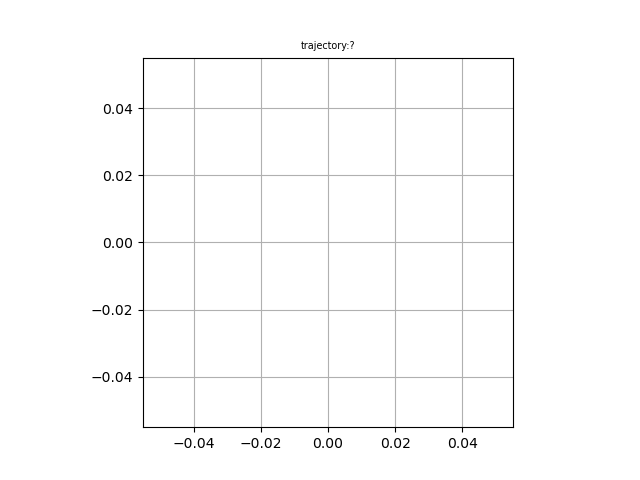

In [4]:
syst = GNbody(10,10,10,10)
v = 1; u = 4; a = -pi/12; d = lambda v:v 
#v = 1; u = 4; a = pi/4; d = lambda v:v # collision!
#v = 1; u = 4; a = -pi/12; d = lambda v:v+.005
ini = (
  (-u,-u,v*cos(a),v*sin(a)),
  (u,-u,-v*sin(a),v*cos(a)),
  (u,u,-v*cos(a),-v*sin(a)),
  (-u,u,v*sin(a),d(-v*cos(a))),
)

SimpySimulation(
  syst.launch(init_y=ini),
  frame_per_stu=25,track=60.
)